## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

from collections import Counter
## Import any other stats/DL/ML packages you may need here.\
## E.g. Keras, scikit-learn, etc.
from keras.applications.vgg16 import VGG16
# model = VGG19(include_top=True, weights='imagenet')

## Do some early processing of your metadata for easier model training:

#### setwd

In [2]:
os.chdir('C:/Users/markluo/Desktop/Creation Mark/1.學習資料/11.kaggle/X-ray')

#### check the data

In [3]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('./Data_Entry_2017.csv')

In [4]:
# glob 列出所有檔案
# os.path.join 將入徑 串起來
# os.path.basename 避開中間的檔案資料夾名稱

In [5]:
all_image_paths = {os.path.basename(x): x for x in glob(os.path.join('images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])

Scans found: 112120 , Total Headers 112120


In [6]:
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(5)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
89840,00022310_002.png,Atelectasis,2,22310,75,F,PA,2540,3036,0.139,0.139,NaN,images_010\images\00022310_002.png
82168,00020213_028.png,Consolidation,28,20213,72,F,AP,3044,2544,0.139,0.139,NaN,images_009\images\00020213_028.png
23328,00006186_006.png,No Finding,6,6186,28,M,AP,2500,2048,0.168,0.168,NaN,images_003\images\00006186_006.png
32906,00008613_012.png,Mass,12,8613,60,F,PA,2658,2753,0.143,0.143,NaN,images_004\images\00008613_012.png
80336,00019745_000.png,No Finding,0,19745,51,M,PA,2992,2991,0.143,0.143,NaN,images_009\images\00019745_000.png


In [7]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
# Todo
# columns name has space delete it
df = all_xray_df.copy()
df.columns = df.columns.str.replace(' ', '_')
# columns fall apart fix it
OriginalImageWidth = df.iloc[: , 7]
OriginalImageHeight = df.iloc[: , 8]
OriginalImagePixelSpacing_x = df.iloc[: , 9]
OriginalImagePixelSpacing_y = df.iloc[: , 9]
df = df.iloc[:,0:7]
df['OriginalImageWidth'] = list(OriginalImageWidth) 
df['OriginalImageHeight'] = list(OriginalImageHeight) 
df['OriginalImagePixelSpacing_x'] = list(OriginalImagePixelSpacing_x) 
df['OriginalImagePixelSpacing_y'] = list(OriginalImagePixelSpacing_y) 
# setting path
df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
df.head(5)

,Image_Index,Finding_Labels,Follow-up_#,Patient_ID,Patient_Age,Patient_Gender,View_Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,images_001\images\00000001_000.png
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,images_001\images\00000001_001.png
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,images_001\images\00000001_002.png
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,images_001\images\00000002_000.png
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,images_001\images\00000003_000.png


In [8]:
# ## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
# ## images with or without pneumonia for binary classification

# # Todo
# # df.shape
# df['disease']=df['Finding_Labels'].str.split('|').str.get(-1)
# df['Pneumonia_or_not'] = np.where(df['disease']=='Pneumonia', 1, 0)
# print('How many case are Pneumonia:',df['Pneumonia_or_not'].sum())
# df.head(5)

In [9]:
# Counter(df['Pneumonia_or_not'])

In [10]:
from itertools import chain
## One Hot Encoding of the Finding Labels Column
all_labels = np.unique(list(chain(*df['Finding_Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        df[c_label] = df['Finding_Labels'].map(lambda finding: 1 if c_label in finding else 0)

del df['Finding_Labels']
df.columns = df.columns.str.replace(' ', '_')

df.head(5)
Counter(df['Pneumonia'])

Counter({0: 110689, 1: 1431})

## Create your training and testing data:

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, \
Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam

In [13]:
def create_splits(df,train_size,column):
   
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    # Todo
    train_data, val_data = train_test_split(df,train_size=train_size,stratify=df[column])
    return train_data, val_data

In [14]:
df['Pneumonia']=df['Pneumonia'].map(str)

In [15]:
train_df, val_df = create_splits(df, 0.8, 'Pneumonia')
print("train_df", train_df.shape)
print("val_df", val_df.shape)

train_df (89696, 26)
val_df (22424, 26)


In [16]:
print("train", train_df['Pneumonia'].map(int).sum()/len(train_df))
print("validation", val_df['Pneumonia'].map(int).sum()/len(val_df))

train 0.012765340706386016
validation 0.012754191937210132


In [17]:
from random import sample 
# train_df[train_df.Pneumonia_or_not=='1']
# Get a balanced dataset (50/50) = equal amount of positive and negative cases in Training
p_inds = train_df[train_df.Pneumonia=='1'].index.tolist()
np_inds = train_df[train_df.Pneumonia=='0'].index.tolist()

In [18]:
# positive 的數量為 len(p_inds)
# 取跟 positive一樣數量的 negative
np_sample = sample(np_inds,len(p_inds))
#
train_df = train_df.loc[p_inds + np_sample]
print("train", train_df['Pneumonia'].map(int).sum()/len(train_df))

train 0.5


In [19]:
# train_df.shape
# val_df.shape
# Get a validation set with at 20% Pneumonia cases
p_inds = val_df[val_df.Pneumonia=='1'].index.tolist()
np_inds = val_df[val_df.Pneumonia=='0'].index.tolist()
np_sample = sample(np_inds,4*len(p_inds))

In [20]:
val_df = val_df.loc[p_inds + np_sample]
print("validation", val_df['Pneumonia'].map(int).sum()/len(val_df))

validation 0.2


In [21]:
Counter(val_df['Pneumonia'])

Counter({'1': 286, '0': 1144})

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [22]:
from keras.preprocessing.image import ImageDataGenerator

In [23]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

In [24]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    my_idg = ImageDataGenerator(rescale = 1 / 255.0,
#                              horizontal_flip = True, 
#                              vertical_flip = False, 
#                              height_shift_range = 0.1, 
#                              width_shift_range = 0.1, 
#                              rotation_range = 25, 
                             shear_range = 0.1,
                             zoom_range = 0.15)
    return my_idg


def make_train_gen(train_df):
    my_idg=my_image_augmentation()
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    train_gen = my_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia',
#                                          class_mode = 'binary',
                                         class_mode = 'raw',
                                         target_size = IMG_SIZE, 
                                         batch_size = BATCH_SIZE
                                         )
    return train_gen


def make_val_gen(valid_df):
    my_idg=my_image_augmentation()
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    val_gen = my_idg.flow_from_dataframe(dataframe = valid_df, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'Pneumonia',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = BATCH_SIZE)
    return val_gen

In [25]:
train_df['Pneumonia'] = train_df['Pneumonia'].astype('int')
# train_df['Pneumonia_or_not']=train_df['Pneumonia_or_not'].map(str)
## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen =make_val_gen(val_df)
valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.


In [26]:
# train_df['Pneumonia']=train_df['Pneumonia'].map(str)

Found 2290 validated image filenames.


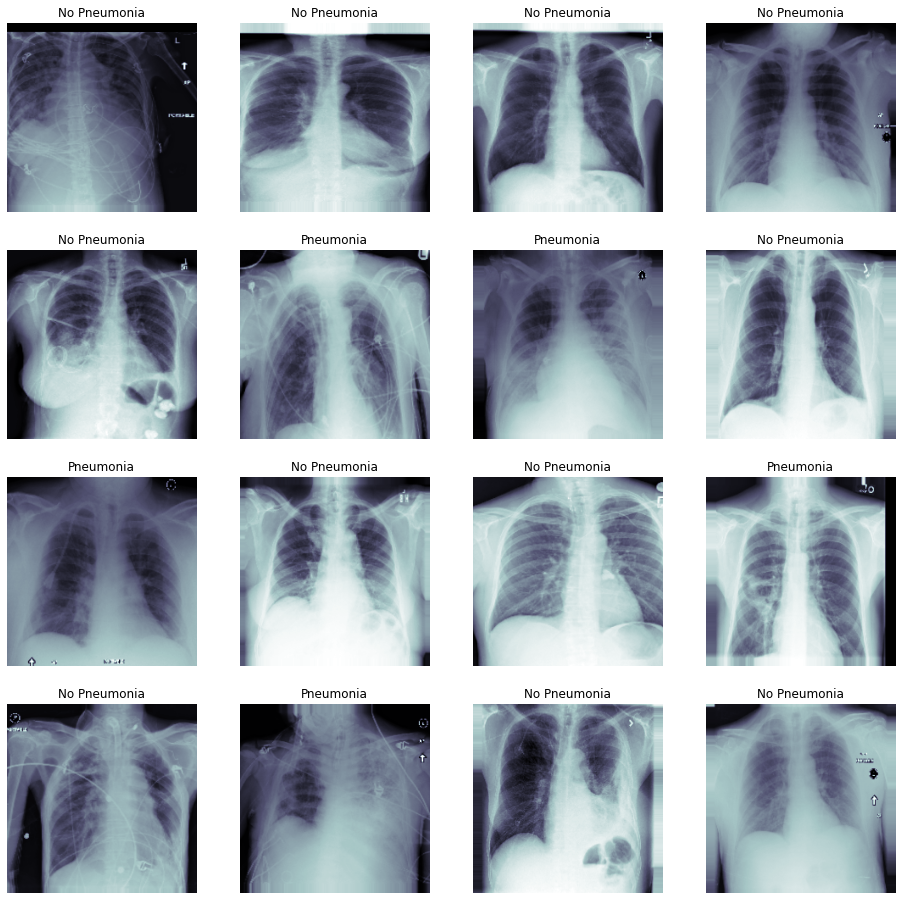

In [27]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
my_idg = my_image_augmentation()
train_gen = make_train_gen(train_df)
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

Found 1145 validated image filenames.


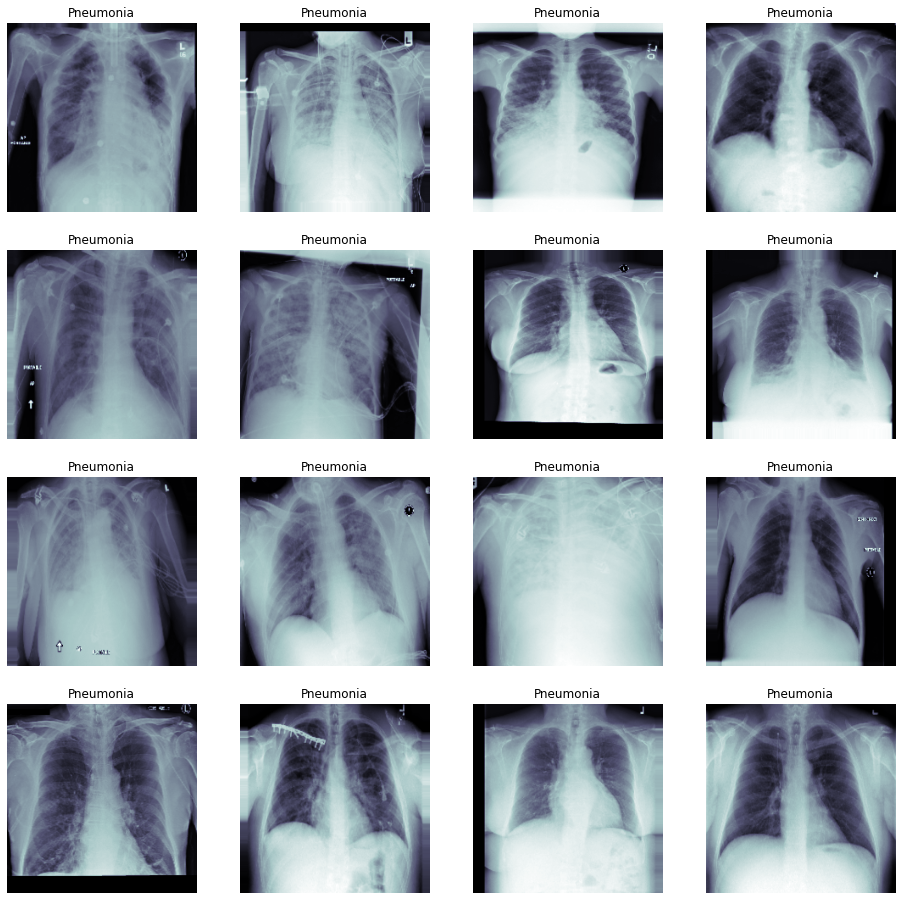

In [28]:
train_df_positve=train_df[train_df.Pneumonia==1]
my_idg = my_image_augmentation()
train_gen = make_train_gen(train_df_positve)
t_x, t_y = next(train_gen)
Counter(train_df_positve['Pneumonia'])
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [29]:
from keras.applications import VGG16

In [30]:
# model =NASNetLarge(include_top=True, weights='imagenet')

In [31]:
def load_pretrained_model(layer_of_interest = "block5_pool"):
    model = VGG16(include_top=True,weights="imagenet")
    transfer_layer = model.get_layer(layer_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    # Todoinput_shape=None,

    for layer in vgg_model.layers[0:17]:
            layer.trainable = False
    return vgg_model

In [55]:
def build_my_model():
#     premodel=load_pretrained_model()
    model = Sequential()
    model.add(load_pretrained_model())
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    # also make sure you set your optimizer, loss function, and metrics to monitor
    # Todo
#     model.add(premodel)
    
    model.add(Flatten())
    model.add(Dropout(0.4))
    
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.3))
    
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.3))
    
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.3))
    
    model.add(Dense(1, activation='sigmoid'))
    return model
## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

### Start training! 

In [56]:
# input_shape = ( None, 224, 224, 3)
my_model = build_my_model()
# my_model.build(input_shape) 
my_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)              

In [57]:
## Set optimizer, loss function, and learning rate
epochs = 30
# learning_rate = 0.001
learning_rate = 1e-4
optimizer = Adam(lr=learning_rate)
loss = 'binary_crossentropy'
metrics = ['accuracy']

my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [58]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training
## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting
# Todo
weight_path="{}_my_model.best.hdf5".format('xray_class')
checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'auto', 
                             save_weights_only = True)
early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'auto', 
                      patience=10)
callbacks_list = [checkpoint, early]
# callbacks_list = [checkpoint]

In [59]:
## train your model
# Todo
history = my_model.fit(train_gen,
                       validation_data = (valX, valY),
                       epochs = epochs,
                       callbacks = callbacks_list)

Epoch 1/30
18/18 [==============================] - 110s 6s/step - loss: 0.1134 - accuracy: 0.9415 - val_loss: 20.1928 - val_accuracy: 0.2188

Epoch 00001: val_loss improved from inf to 20.19283, saving model to xray_class_my_model.best.hdf5
Epoch 2/30
18/18 [==============================] - 105s 6s/step - loss: 5.3336e-10 - accuracy: 1.0000 - val_loss: 25.0861 - val_accuracy: 0.2188

Epoch 00002: val_loss did not improve from 20.19283
Epoch 3/30
18/18 [==============================] - 106s 6s/step - loss: 5.4723e-11 - accuracy: 1.0000 - val_loss: 26.0695 - val_accuracy: 0.2188

Epoch 00003: val_loss did not improve from 20.19283
Epoch 4/30
18/18 [==============================] - 106s 6s/step - loss: 3.0754e-11 - accuracy: 1.0000 - val_loss: 26.2473 - val_accuracy: 0.2188

Epoch 00004: val_loss did not improve from 20.19283
Epoch 5/30
18/18 [==============================] - 108s 6s/step - loss: 1.3169e-11 - accuracy: 1.0000 - val_loss: 26.2778 - val_accuracy: 0.2188

Epoch 00005: v

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [60]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)
val_Y = val_df['Pneumonia']
pred_Y = my_model.predict(val_gen, verbose = True)

23/23 [==============================] - 119s 5s/step


In [63]:
# sum(pred_Y>0.5)

In [80]:
pred_Y

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]], dtype=float32)

In [64]:
# ggyy=np.where(pred_Y>=0.513, 1, 0)
# my_list = map(lambda x: x[0], ggyy)
# ser = pd.Series(my_list)
# Counter(ser)

In [65]:
# val_Y=val_Y.map(int)

In [66]:
# ggyy=np.where(pred_Y>=0.5, 1, 0)

In [67]:
# Counter(pd.DataFrame(ggyy))

In [68]:
# Counter(val_Y)

In [69]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, \
average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

In [70]:
# function to plot the roc_curve
def plot_auc(t_y, p_y):
    fpr, tpr, thresholds = roc_curve(t_y, p_y, pos_label=1)
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')

In [71]:
# fpr, tpr, thresholds = roc_curve(val_Y, test_ggyy, pos_label=1)
# fig, c_ax = plt.subplots(1,1, figsize = (9, 9))

In [72]:
## what other performance statistics do you want to include here besides AUC? 

# def ...
# Todo
def plot_history(history):
    f = plt.figure()
    f.set_figwidth(15)

    f.add_subplot(1, 2, 1)
    plt.plot(history.history['val_loss'], label='val loss')
    plt.plot(history.history['loss'], label='train loss')
    plt.legend()
    plt.title("Modell Loss")
    
    f.add_subplot(1, 2, 2)
    plt.plot(history.history['val_accuracy'], label='val accuracy')
    plt.plot(history.history['accuracy'], label='train accuracy')
    plt.legend()
    plt.title("Modell Accuracy")

    plt.show()
    # Todo
#     return

In [73]:
## plot figures
# Todo

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [74]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.
# Todo

In [75]:
## Let's look at some examples of true vs. predicted with our best model: 
# Todo
# fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
# i = 0
# for (c_x, c_y, c_ax) in zip(valX[0:100], testY[0:100], m_axs.flatten()):
#     c_ax.imshow(c_x[:,:,0], cmap = 'bone')
#     if c_y == 1: 
#         if pred_Y[i] > YOUR_THRESHOLD:
#             c_ax.set_title('1, 1')
#         else:
#             c_ax.set_title('1, 0')
#     else:
#         if pred_Y[i] > YOUR_THRESHOLD: 
#             c_ax.set_title('0, 1')
#         else:
#             c_ax.set_title('0, 0')
#     c_ax.axis('off')
#     i=i+1

In [76]:
def plot_precision_recall_curve_helper(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y, pos_label=1)
    aps = average_precision_score(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)'  % ('Pneumonia_or_not', aps))
    c_ax.plot(recall, precision, color='red', lw=2)
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
#Also consider plotting the history of your model training:

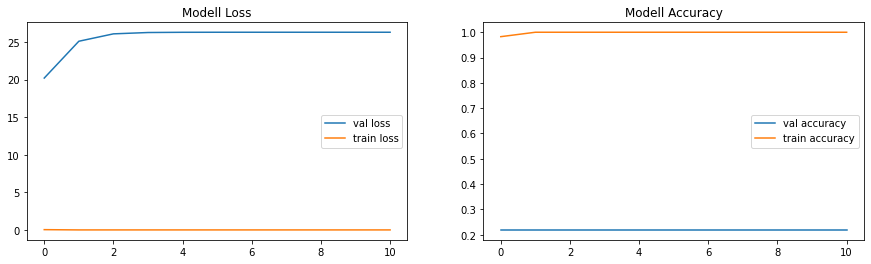

In [77]:
hist = plot_history(history)

C:\Users\markluo\Anaconda3\lib\site-packages\sklearn\metrics\_ranking.py:811: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn("No positive samples in y_true, "


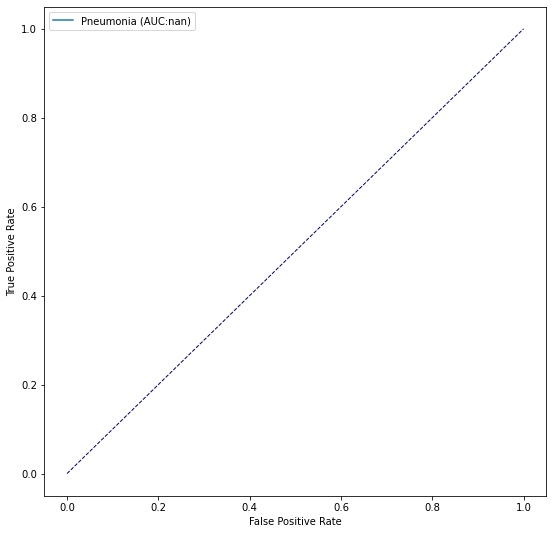

In [78]:
plot_auc(val_Y, pred_Y)

ValueError: pos_label=1 is invalid. Set it to a label in y_true.

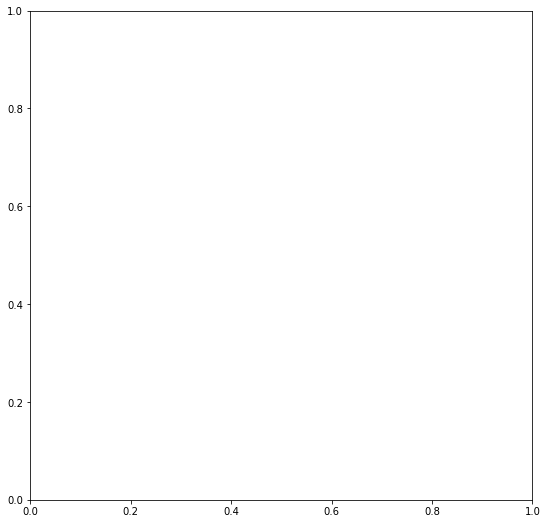

In [81]:
plot_precision_recall_curve_helper(val_Y, pred_Y)

In [82]:
## Just save model architecture to a .json:
model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

In [83]:
def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall) if recall and prec else 0
precision, recall, thresholds = precision_recall_curve(val_Y, pred_Y)
f1score = [calc_f1(precision[i],recall[i]) for i in range(len(thresholds))]
idx = np.argmax(f1score)
threshold = thresholds[idx]
print('Precision: '+ str(precision[idx]))
print('Recall: '+ str(recall[idx]))
print('Threshold: '+ str(thresholds[idx]))
print('F1 Score: ' + str(f1score[idx]))

ValueError: y_true takes value in {'0', '1'} and pos_label is not specified: either make y_true take value in {0, 1} or {-1, 1} or pass pos_label explicitly.

In [ ]:
plt.figure()
plt.plot(thresholds, f1score)
plt.title("F1-Score vs Threshold")
plt.xlabel("Epochs")
plt.ylabel("F1-Score")
plt.show()

In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 
fig, m_axs = plt.subplots(5, 5, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:25], valY[0:25], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > threshold :
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > threshold : 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [ ]:
model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)